# Stochastic Variational Inference Part 1 - Introduction & Explanation

This article, part one of two, is for readers who are brand new to SVI, or at least to using it in NumPyro. The next few sections cover three main topics:
1. What SVI is at a fundamental level
2. What SVI looks like in a simple 1D case, and how to use it in NumPyro
3. A few simplified cases demonstrating how to make SVI guides more quickly when the posterior is simple, and how to make your own more expressive guides when it isn't.

This article is instructive, not demonstrative. If you want to get a feel for _why_ SVI is useful over MCMC, you might want to skip ahead to part 2, where I pit the two head to head, and then circle back to here.

**Contents**
- [Underlying Theory](#theory)
- [Doing SVI in NumPyro](#numpyro)
    - [Fitting Approximate Models](#approximate_models)
- [Interpreting Results](#interpreting)
    - [Getting MCMC-Like Chains out of SVI](#predictive_MCMClike)
	- [Generating Mock Observations](#mock_observations)
	- [Checking for Covergence](#convergence)
- [Some Small Examples](#small_examples) 
    - [Building Non-Trivial SVI Guides](#mixtures)
    - [Automatic Guide Generation](#autoguides)

## How it Works <a id='theory'></a>

In SVI, we seek to tweak the tuning variables $\phi$ of our surrogate model $q_{\phi}(z)$ until it is a close match to the true posterior $p(z)$, but how exactly do we define the two distributions to be 'similar'? The traditional method in SVI to use to use the **Kullback–Leibler Divergence** (KLD) between the two distributions:

$$
    KL_{p \rightarrow q_{\theta}} 
    = \mathbb{E_{q_{\theta}}} \left[ \ln \lvert \frac{q_{\theta}(z)}{p(z)} \rvert \right]  
    = \int{   q_{\theta}(z) \ln \lvert \frac{q_{\theta}(z)}{p(z)} \rvert } dz
$$

The KL Divergence also shows itself in discussions about the "information" or "entropy" of distributions, measures of how well they constrain parameters, but in this case we can just think of it as a measure of the "distance" we seek to minimize between our two distributions. It's worth noting that $KL=0$ when $q_{\theta}(z) = p(z)$, which tells us that KL is strictly positive: $KL \ge 0$. In most applications, we don't _actually_ have access to the normalized posterior distribution $p(z)$, and instead will have it in the un-normalized form that we normally perform MCMC on. We can evaluate the "shape" of the posterior, but only up to its normalizing constant / evidence '$Z$':

$$
    P(z) = \pi(z) \cdot \mathcal{L}(z) = Z p(z), \;\; Z = \int{P(z)}dz
$$

Having the evidence is basically the same as having already solved for $p(z)$, and so we want to express the KL divergence in a way that it can be minimized without knowing $Z$:

\begin{eqnarray}
    KL_{p \rightarrow q_{\theta}} 
    = & \mathbb{E_{q_{\theta}}} \left[ \ln \lvert \frac{P(z)}{q_{\theta}(z)} \rvert \right] + \mathbb{E_{q_{\theta}}} \left[ \ln \lvert Z \rvert \right]\\
    = & -\text{ELBO} + \ln \lvert Z \rvert \\
\end{eqnarray}

Here we've defined the **Evidence Lower Bound** (ELBO), an evidence-free proxy for the KL-divergence. Rather than "minimizing the KL-divergence", we speak in terms of "maximizing the ELBO", to the same end. The name comes from the fact that it acts as a lower bound for the _true_ posterior's log-evidence:

$$
    0 \le KL_{p \rightarrow q_{\theta}}  = -\text{ELBO} + \ln \lvert Z \rvert  
    \;\; \rightarrow \;\; 
    \text{ELBO} \le \ln \lvert Z \rvert
$$

This is the core of SVI: we optimize the surrogate model's tuning parameters to maximize the ELBO. There are some special-case versions of SVI with analytical solutions, but in NumPyro terms this is a pure numerical optimization problem, well suited to JAX's autodiff. Obviously, $\text{ELBO} = \mathbb{E_{q_{\theta}}} \left[ \ln \lvert \frac{q_{\theta}(z)}{P(z)} \rvert \right]$ is an expectation value and still requires some integration over $q_{\theta}(z)$. This is done via Monte-Carlo integration, hence the "stochastic" part of "stochastic variational inference". Because we're only using it to navigate instead of defining the entire distribution, this integral can afford to be sparsely sampled without breaking our engine.

The broad overview of SVI is then:
 1. Choose a surrogate distribution form that approximates the true posterior after some tuning
 2. Use Monte Carlo integration to estimate the ELBO (and its gradients with respect to $\theta$)
 3. Using numerical optimization, tweak $\theta$ until the ELBO reaches a stable maximum

<p style="text-align: center;"> 
<figure>
    <img src="./EXAMPLEGRAPH.png" width="600">
</figure>

<p style="text-align: center; font-family: arial;width: 600px; margin:0 auto;" ><b>Example of a PDF fit with SVI, drawn with an open-source<a href="https://www.padowan.dk/">Graph Program</a></b></p></p>

-----

## Doing SVI in NumPyro <a id='numpyro'></a>
NumPyro has ready-made tools for doing SVI without much more complexity than an MCMC run. As a quick overview, an SVI job consistent of four components:

1. A standard NumPyro model that can generate a posterior and defines latent variables in the form of `numpyro.samples`
2. A numpyro "guide" that defines surrogate sample distributions in in terms of the optimizeable `numpyro.parameters`
3. A JAX optimizer from the `numpyro.optim` module
4. And a `numpyro.infer.SVI`object that takes in all of the above to perform the SVI run. This is analogous to the `numpyro.infer.MCMC` object we use in MCMC, a "handler" for our various objects and results

After running the SVI job, we can use the optimized surrogate distribution to generate recover MCMC chain-like sets of points in parameter space or to make mock data corresponding to these points.

In [1]:
import numpyro
import numpyro.distributions as dist
from numpyro.distributions import constraints
from numpyro.infer import Predictive, SVI, Trace_ELBO

import jax.numpy as jnp
import jax, jaxopt
from jax import random

import numpy as np
import matplotlib.pyplot as plt
from chainconsumer import ChainConsumer

### Heads or Tails: A Simple Model
As a first example, we'll go over a variation of the the heads / tails example from the [old pyro documentation](http://pyro.ai/examples/svi_part_i.html) and the modern (but incomplete) equivalent from the [NumPyro documentation](https://num.pyro.ai/en/stable/svi.html). The basic setup is simple: we have a coin being tossed a certain number of times, landing heads $A$ times and tails $B$ times in no particular order. We're seeking to constrain the "fairness" of the coin, '$f$', the probability of it landing heads on any given flip.

This problem has a well known analytical solution: the PDF for $f$ is given by a [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution), a close cousin to the binomial distribution, but giving the probability of the fairness rather than the number of events:

$$
    \beta(f,A,B) = \frac{1}{C}  f^{A-1}\cdot f^{B-1}
$$

Where the normalizing constant $C$ is given in terms of Gamma Functions:

$$
    C = \frac{\Gamma(A+B)}{\Gamma(A) \Gamma(B)}
$$

The beta distribution has known mean and variance:

$$
    \text{mean}(\beta) = \frac{A}{A+B} \;\;\;\;
    \text{var}(\beta) = \frac{AB}{(A+B)^2 (A+B+1)}
$$

And, in the limit $\lim_{A,B} \rightarrow \infty$, converges to a normal distribution with:

$$
    \text{mean}(N) = \frac{A}{A+B} \;\;\;\;
    \text{var}(N) = \frac{\text{mean}(N)\cdot(1-\text{mean}(N))}{A+B}
$$

In this example, we'll model the data with a binomial distribution, and then use SVI to fit a $\beta$ distribution to $f$, and use SVI again to instead fit an approximate gaussian.

**Generating Data & Model** <a id='approximate_distributions'></a>

First we generate some test data. In our case, this is a series of coin flips with $A=12$ heads and $B=8$ tails, so the maximum likelihood is $\hat{f}=60\%$:

In [2]:
# Actual head and tails
A_true, B_true = 12, 8 
data_headstails = jnp.concatenate([jnp.ones(A_true), jnp.zeros(B_true)])

# Mean & Var
mean_true, var_true = A_true/(A_true + B_true), (A_true*B_true / (A_true + B_true)**2 / (A_true + B_true+1))**0.5

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


For a given fairness, the probability of any coin toss landing heads or tails follows a [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution), such that the entire run of heads and tails follows a binomial distribution:

$$
    p(f \vert A,B) \propto \prod_A \text{Bernoulli}(f) \cdot \prod_B \text{Bernoulli}(1-f)
$$

And we can construct this as a model in NumPyro:

In [3]:
def model_headstails(data):
    '''
    'f' is the fairness of the coin flip, with a uniform prior
    '''
    # Uniform prior on fairness
    f = numpyro.sample("latent_fairness", dist.Uniform(0, 1))

    # Each coin toss has an f:1-f chance of landing heads / tails:
    with numpyro.plate("N", data.shape[0] if data is not None else 10): # Second half used for generating mock data later
        # Now acquire the likelihood of getting `data` if 'f' was accurate
        numpyro.sample("obs", dist.Bernoulli(f), obs=data)

**Fitting A Beta Distribution with SVI**

Now onto the actual SVI work. The biggest difference between MCMC and SVI in NumPyro is the '_guide_', a python function that tells numpyro about the  surrogate distribution and what variables we tune such that this distributions minimizes the ELBO. Unlike numpyro models, guides include non-stochastic variables that are used for optimization instead of sampling / integration. These parameters are identified by variables marked as `numpyro.param`, while the model latent variables are all `numpyro.samples`, with the `samples` being drawn from distributions that depend on the `params`.

In this part, we'll construct a guide for a generic $\beta$ distribution, which has two `params` to optimize: $A$ and $B$. Notice that we apply constraints on the variables, in this case defining that $A,B>0$. All constraints come from `numpyro.distributions.constraints`, and you can find a full list in the [NumPyro documentation](https://num.pyro.ai/en/stable/_modules/numpyro/distributions/constraints.html). We also need to specify an initial value for the optimization to begin at, taking care to ensure this value doesn't violate these constraints:

In [4]:
def guide_beta(data):
    '''
    The 'guide' describes the set of surrogate functions we can approximate likelihood function with
    In this case, surrogate functions are the family beta(f,A,B).
    '''
    alpha_q = numpyro.param("alpha_q", # Site Name
                            20.0/2.0, # Initial value in optimization
                            constraint=constraints.positive) 
    beta_q = numpyro.param("beta_q", 
                           20.0/2.0,  # Note that this init value _needs_ to be a float as its a continuous param
                           constraint=constraints.positive)
    
    numpyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))

Now the fun part: we construct an `SVI` object just like we would an `MCMC` object: feeding it the statistical modeling (in his case a model and guide) and a solution method (in this case an optimizer and a loss function). The loss being given as `Trace_Elbo()` just refers to us minimizing the KL divergence in a model with entirely continuous variables, something we won't need to touch in most cases. We also make an `Adam` optimizer, `JAX`'s native autodiff-based stochastic optimization routine that will let the `SVI` object navigate to the best $\theta$.

We fire this off with `.run()`, and collect our results just as we would with an MCMC run:

In [5]:
# Make a JAX optimizer
optimizer = numpyro.optim.Adam(step_size=0.0005)

# Make and run the SVI object
svi_beta = SVI(model_headstails, guide_beta, optimizer, loss=Trace_ELBO())
svi_beta_result = svi_beta.run(random.PRNGKey(1), num_steps = 10000, data = data_headstails)

100%|████| 10000/10000 [00:01<00:00, 5667.57it/s, init loss: 18.0005, avg. loss [9501-10000]: 14.7887]


The optimal `param` values are stored as a keyed dictionary in the `svi_beta_result` object, and we can extract these to see our best fit surrogate model. In this instance, we know both the ground truth for the parameters _and_ an analytical solution for the pdf of $f$, and so we can see how well SVI has done at recovering the true distribution. We can see that SVI has, in short order, recovered the parameters to within $\approx 10 \%$, and has similarly recovered import summary statistics like the mean and variance of the pdf:

----------------------------------------------------------------------------
	 Truth 	 SVI
A 	 12.0 	 12.3
B 	 8.0 	 8.6
Mean 	 0.60 	 0.59
Var 	 0.11 	 0.11
----------------------------------------------------------------------------


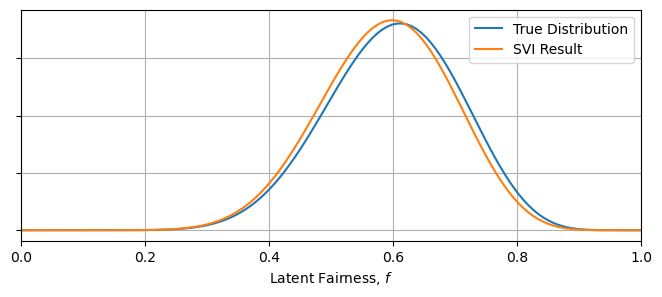

In [6]:
from scipy.stats import beta, norm

#----------------------------------
params_beta = svi_beta_result.params
A_beta, B_beta = params_beta["alpha_q"], params_beta["beta_q"]

# Get Mean & Var of beta(A,B) for A,B recovered by SVI
inferred_mean = A_beta / (A_beta + B_beta)
inferred_var  = (A_beta * B_beta / (A_beta + B_beta)**2 / (A_beta + B_beta+1))**0.5

#----------------------------------
print("-"*76)
print("\t Truth \t SVI")
print("A \t %0.1f \t %0.1f" %(A_true, params_beta["alpha_q"]))
print("B \t %0.1f \t %0.1f" %(B_true, params_beta["beta_q"]))
print("Mean \t %0.2f \t %0.2f" %(mean_true, inferred_mean))
print("Var \t %0.2f \t %0.2f" %(var_true, inferred_var))
print("-"*76)
#----------------------------------

Xplot = np.linspace(0,1,128)
plt.figure(figsize = (8,3))
plt.plot(Xplot, beta(A_true,B_true).pdf(Xplot), label = "True Distribution")
plt.plot(Xplot, beta(params_beta["alpha_q"], params_beta["beta_q"]).pdf(Xplot), label = "SVI Result")
plt.xlim(0,1)
plt.gca().yaxis.set_ticklabels([])
plt.xlabel("Latent Fairness, $f$")
plt.grid()
plt.legend()

plt.show()

**Fitting Approximate Models with SVI** <a id='approximate_models'></a>

In our simple toy model, we were able to define a guide that, if properly optimized, SVI recovers the _exact_ solution of the $\beta$ distribution. We rarely enjoy this luxury in the real world, as cases with analytical solutions aren't really the use case for numerical statistical methods. A more realistic use case for SVI is in fitting a simplified surrogate model that emulates a reasonable fit to the posterior without matching it exactly. In a lot of applications we crunch the posterior down to a mean and standard deviation anyway, and so we can imagine a "best fit Gaussian" as being a useful tool.

As an example in our heads / tail case, we can see that $\beta$ distributions are _almost_ Gaussian for large numbers of trails, and so we might consider using SVI to fit a normal distribution instead. As before, we define a guide that describes the set of all surrogate distributions, this time tuning the mean and standard deviation of our Gaussian:

In [7]:
def guide_normal(data):
    mean = numpyro.param("mean", 
                            0.5, 
                            constraint= constraints.unit_interval)
    var = numpyro.param("var", 
                           0.1,
                           constraint=constraints.positive)
    
    numpyro.sample("latent_fairness", dist.Normal(mean, var))

svi_norm = SVI(model_headstails , guide_normal, optimizer, loss=Trace_ELBO())
svi_result_norm = svi_norm.run(random.PRNGKey(2), 50000, data_headstails)

100%|██| 50000/50000 [00:03<00:00, 15223.95it/s, init loss: 15.5589, avg. loss [47501-50000]: 14.7973]


Running this, we acquire the Gaussian that is of closest fit to the $\beta$ distribution. As $\beta$ is non-Gaussian, there is an unavoidable discrepancy between the two, but we still recover important summary statistics like the mean and variance of the distribution. This is one of SVI's key utilities: as long as your surrogate model can be tuned to _roughly_ match the true posterior, it can produce useful results.

----------------------------------------------------------------------------
	 Truth 	 SVI
Mean 	 0.60 	 0.59
B 	 0.11 	 0.10
----------------------------------------------------------------------------


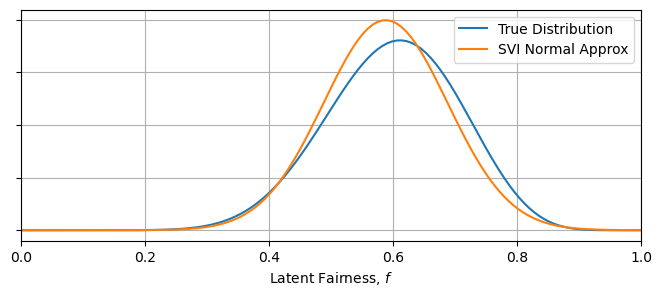

In [8]:
params_norm = svi_result_norm.params

#----------------------------------
print("-"*76)
print("\t Truth \t SVI")
print("Mean \t %0.2f \t %0.2f" %(mean_true, params_norm["mean"]))
print("B \t %0.2f \t %0.2f" %(var_true, params_norm["var"]))
print("-"*76)
#----------------------------------

Xplot = np.linspace(0,1,128)
plt.figure(figsize = (8,3))
plt.plot(Xplot, beta(A_true,B_true).pdf(Xplot), label = "True Distribution")
plt.plot(Xplot, norm(params_norm["mean"],params_norm["var"]).pdf(Xplot), label = "SVI Normal Approx")
plt.xlim(0,1)
plt.gca().yaxis.set_ticklabels([])
plt.xlabel("Latent Fairness, $f$")
plt.grid()
plt.legend()

plt.show()

There is a slight detail that I've smoothed over here: the $\beta$ distribution is technically only defined on the interval $x\in[0,1]$, while the normal distribution is defined over all real numbers. The two distributions have different [supports](https://en.wikipedia.org/wiki/Support_(mathematics)). We can get away with this discrepancy in this well behaved case, but mixing and matching dissimilar distributions can lead to badly fit surrogate distributions, and can even break the numerical fitting procedure.

## Acquiring / Interpreting Results from SVI <a id='interpreting'></a>

Once an SVI optimization has run, the most general way to convert the optimal results back into measurement space or parameter space is to use the `infer.Predict` object in NumpPyro. In regards to SVI, we have three paths of interest:
1. [One](#): Feeding a model _and_ optimized guide into a `Predict` object to yield mock observations
2. [Two](#predictive_MCMClike): Feeding _just the guide_ and its optimal tuning gives us samples in parameter space
3. [Three](#): We can feed parameters from (2) and a model to get fake observations

### Getting MCMC-Like Posterior Samples <a id='predictive_MCMClike'></a>

Given MCMC is the go-to tool of most Bayesian statisticians, it's useful to be able to take an SVI result and pull out something like an MCMC chain: an array of independent samples distributed proportional to their posterior probability. Fortunately, NumPyro's `infer.Predict` object does much of the heavy lifting for us in this regard. We can draw out an MCMC-like chain of samples in only one or two lines by the feeding `Predict` a model or guide along with the result of our optimization:

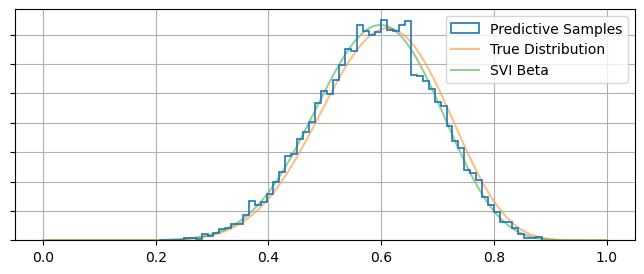

In [9]:
# get posterior samples
predictive_MCMClike = Predictive(guide_beta, params=svi_beta_result.params, num_samples=10000)
posterior_samples = predictive_MCMClike(random.PRNGKey(1), data=None) # Don't supply data here! Conditioning already performed by the optimization

#------------------
# Plotting
plt.figure(figsize = (8,3))

plt.hist(posterior_samples['latent_fairness'], bins = 64, histtype='step', density=True, label = "Predictive Samples", lw = 1.2, zorder = 10)
plt.plot(Xplot, beta(A_true, B_true).pdf(Xplot), label = "True Distribution", zorder = -1, alpha= 0.5)
plt.plot(Xplot, beta(A_beta, B_beta).pdf(Xplot), label = "SVI Beta", zorder = -1, alpha= 0.5)

plt.gca().yaxis.set_ticklabels([])
plt.legend()
plt.grid()

plt.show()

### Mock Observations <a id='mock_observations'></a>
Alternately, we use `Predict` to generate some mock-data according to our surrogate posterior. In the following, we use the optimal surrogate distributions to draw many different weights for the coin, and use these to guide our NumPyro model to generate random mock-inputs that would emulate the statistical properties of our input data:

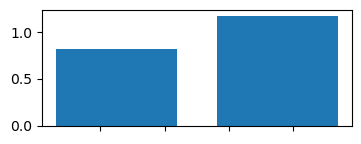

In [10]:
# use guide to make predictive
predictive_fromguide = Predictive(model_headstails, guide=guide_beta, params=svi_beta_result.params, num_samples=1000)
samples_fromguide = predictive_fromguide(random.PRNGKey(1), data=None)

plt.figure(figsize = (4,1.5))
plt.hist(samples_fromguide['obs'].reshape(1000*10),bins=2, rwidth=0.75, density=True)
plt.gca().set_xticklabels([])
plt.show()


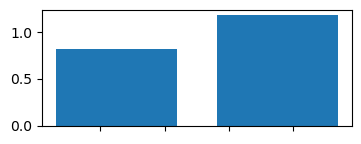

In [11]:
# use posterior samples to make predictive
predictive_fromsamples = Predictive(model_headstails, posterior_samples, params=svi_beta_result.params)
samples_fromsamples = predictive_fromsamples(random.PRNGKey(1), data=None)

plt.figure(figsize = (4,1.5))
plt.hist(samples_fromsamples['obs'].reshape(10000*10),bins=2, rwidth=0.75, density=True)
plt.gca().set_xticklabels([])
plt.show()

### Ensuring Convergence <a id='convergence'></a>
One danger of SVI is that it is at the mercy of the optimizer you tune it with. Unlike MCMC, where we can identify poor convergence by eye, SVI's smooth distributions can give misleading confidence, especially when using an optimizer like `Adam` which doesn't have any self-halting criteria. It's up to the user to choose a size and number of steps for this optimization, and it's important double check that this process has actually converged to an optimal surrogate model. 

A quick and easy way to do this is to check the loss function / ELBO to make sure it has settled out to a plateau value, which we can do by retrieving the losses from the `SVIRunResult` object:

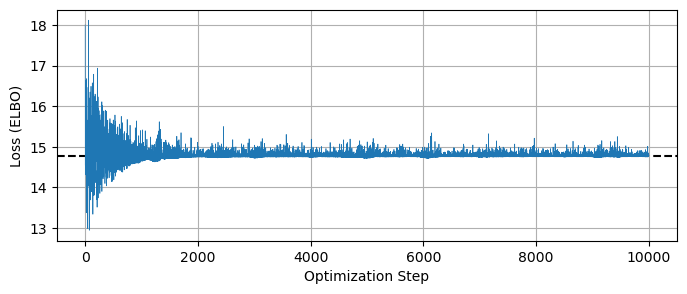

In [12]:
LOSSES = svi_beta_result.losses

plt.figure(figsize = (8,3))
plt.plot(LOSSES, lw=0.5)
plt.axhline(np.median(svi_beta_result.losses[::-100]), c='k', ls='--', zorder = -1)
plt.xlabel("Optimization Step"), plt.ylabel("Loss (ELBO)")
plt.grid()
plt.show()

Similarly, we need to be careful of the usual pitfalls of optimization like multimodality and local optima. You'll also notice that the loss function doesn't quite settle out to a minumum, and jumps around a bit. This variance is an unavoidable feature of the stochastic nature of the ELBO evaluation, but we can get a smoother result if we change the `num_particles` argument in the `Trace_ELBO` loss function calculator when doing SVI. For example, re-running our beta distribution fit, but this time using `num_particles = 32` instead of the default value of 1:

100%|████| 10000/10000 [00:02<00:00, 3747.47it/s, init loss: 15.1206, avg. loss [9501-10000]: 14.7885]


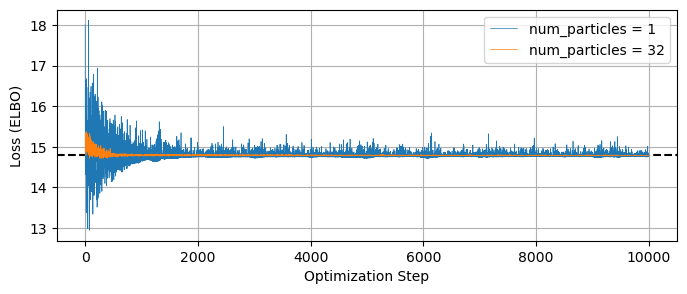

In [13]:
# Make and run the SVI object with more ELBO particles
svi_beta = SVI(model_headstails, guide_beta, optimizer, loss=Trace_ELBO(num_particles = 32))
svi_beta_result = svi_beta.run(random.PRNGKey(1), num_steps = 10000, data = data_headstails)

plt.figure(figsize = (8,3))
plt.plot(LOSSES, lw=0.5, label = 'num_particles = 1')
plt.plot(svi_beta_result.losses, lw=0.5, label = 'num_particles = 32')
plt.legend()
plt.axhline(np.median(svi_beta_result.losses[::-100]), c='k', ls='--', zorder = -1)
plt.xlabel("Optimization Step"), plt.ylabel("Loss (ELBO)")
plt.grid()
plt.show()

The gradient of this ELBO estimate is what guides the SVI optimization, and so increasing `num_particles` should may improved performance if you're having issues with convergence.

## Some Small Examples <a id="small_examples"></a>

### Building a Complicated Models From Mixtures <a id='mixtures'></a>

In the previous example we worked with a simple 1-parameter case, and it's easy to extend that working out to multidimensional cases where our surrogate model has similarly simple and independent distributions for each parameter. Of course, many cases are sadly not like this: how do we construct guides that account for things like reparameterization, correlated variables or multimdal distributions? 

Here, I outline an example of a less-than-simple posterior and a way to construct a guide that can approximate it, and then try to fit a multimodal Gaussian mixture model to this distribution using SVI. In real-world use cases, the posterior will come from a model conditioned by some set of data, but in this example I'll take the shortcut of defining an arbitrary posterior with some non-trivial geometry. Specifically, I'm going to use a distribution that is multimodal and Gaussian:

$$
q(x,y) =  [e^{-(u_1-b)^2} + e^{-(u_1+b)^2}]\cdot \frac{1}{1+u_2^2}
$$

Where $u_1$ and $u_2$ are principle axis' aligned at 45 degrees:

$$
u_1 = cos(\theta) x - sin(\theta) y, \;\;\; u_2 = cos(\theta) x + sin(\theta) y
$$

First, construct this distribution as a NumPyro model:

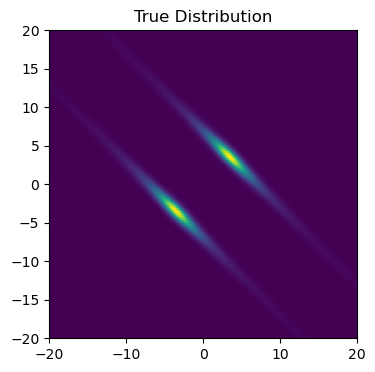

In [14]:
sig1, sig2 , b = 0.5, 2.0, 5.0

def log_distribution(x,y):
    '''
    An arbitrary distribution, multimodal & correlated
    '''
    sqrt2 = 2**0.5
    
    f1 = jnp.exp(-1/2* (((x+y)/sqrt2 - b)/sig1)**2 )
    f2 = jnp.exp(-1/2* (((x+y)/sqrt2 + b)/sig1)**2 )
    
    log_fac = jnp.log(f1+f2) # Multimodal normal distribution along axis 1
    log_fac +=  + jnp.log(1 / (1 + ((x-y)/sig2 / sqrt2)**2 /2 )) # Cauchy dist along axis 2

    return(log_fac)

def model_multimodal():
    '''
    A numpyro model for that reproduces log_distribution
    '''
    x = numpyro.sample('x', numpyro.distributions.Uniform(-20,20))
    y = numpyro.sample('y', numpyro.distributions.Uniform(-20,20))
    
    log_fac = log_distribution(x,y)
        
    numpyro.factor('logfac', log_fac)

#-----------------------------
# Plot
plt.figure(figsize=(4,4))

X, Y = np.meshgrid(np.linspace(-20,20,128),np.linspace(-20,20,128))
Z = np.exp(log_distribution(X,Y))
plt.imshow(Z[::-1], extent = [-20,20,-20,20])
plt.axis('square')
plt.title("True Distribution")
plt.show()


Now we need to construct an SVI guide to describe our surrogate distribution. As always, we need to assume some approximate shape to the distribution, and I'm going to go with two gaussians rotated at angle $\theta$, separated by distance $b$, of equal height and with principle axis variances $\sigma_1$ and $\sigma_2$. To construct this as a guide, we need to use two tricks:
1. Using the `numpyro.distributions.MixtureGeneral` to create the two modes
2. Using a trick with `dist.Delta` to reparameterize the samples back into the latent model variables '$x$' and '$y$'

In [15]:
def guide_multimodal():
    '''Multimodal guide'''

    # Define model parameters
    sig1_q = numpyro.param('sig1_q', 1.0, constraint = constraints.positive) # Principle axis variance 1
    sig2_q = numpyro.param('sig2_q', 1.0, constraint = constraints.positive) # Principle axis variance 2
    b      = numpyro.param('b'     , 1.0, constraint = constraints.positive) # Mode separation

    theta = numpyro.param('theta', 0.0, constraint = constraints.interval(-np.pi/2, np.pi/2)) # Rotation

    #-------------------------------------
    # Gaussian Mixture model along axis u1
    weighting = jnp.array([0.5,0.5])
    gauss_mix = numpyro.distributions.MixtureGeneral(
        dist.Categorical(weighting),
        [
            dist.Normal(loc=b, scale=sig1_q),
            dist.Normal(loc=-b, scale=sig1_q)
        ]
    )
    u1 = numpyro.sample("u1", gauss_mix ,infer={'is_auxiliary': True})

    # Simple gaussian distribution along u2
    u2 = numpyro.sample("u2", dist.Normal(0,sig2_q) ,infer={'is_auxiliary': True})

    #-------------------------------------    
    # Convert to 'x' and 'y' to line up with numpyro model latent site names
    c, s = jnp.cos(theta), jnp.sin(theta)

    x = numpyro.sample('x', dist.Delta(c*u1 - s*u2))
    y = numpyro.sample('y', dist.Delta(c*u2 + s*u1))
    

In the guide, the `dist.Categorical` represents the fact that any given sample has a 50/50 chance of being drawn from one mode or the other, while the list that comes as the second argument of `MixtureGeneral` contains the distributions describing each mode. If you wanted to allow the mode heights to vary, you could add another `param` to tune the weights of the modes, e.g:

```python
    weight = numpyro.param('weight', 0.5, constraint = constraints.unit_interval)
    weighting = jnp.array([weight, 1-weight])
```

In this guide we've used the trick of separating the surrogate distribution out into two factors, $q(x,y)= q_1(u_1) \cdot q_2(u_2)$. We just need to sample $u_1$ and $u_2$ from their respective distributions and convert back into the parameters we actually care about with a deterministic reparameterization: $x=x(u_1,u_2)$ and $y=y(u_1,u_2)$. Strangely, the `numpyro.deterministic` object isn't the right tool for the job here, as NumPyro requires $x$ and $y$ to be `sample` type objects. Instead, we accomplish the same end goal by constraining them with a `delta` distribution, as $x \sim \delta(x')$ is the same as saying $x=x'$.

With our guide set up, we can just run the SVI optimization the same as we would for a 1D model. As always, it's worth plotting the losses to make sure everything has converged properly:

100%|█████| 10000/10000 [00:02<00:00, 3806.81it/s, init loss: 40.1734, avg. loss [9501-10000]: 4.4520]


Optimal Guide Params
----------------------------------------------------------------------------
b:	4.990
sig1_q:	0.505
sig2_q:	4.676
theta:	44.7 deg
----------------------------------------------------------------------------


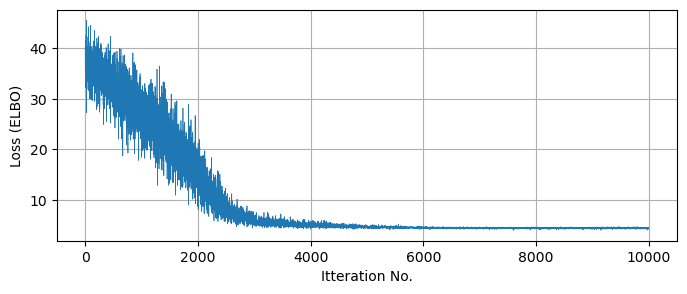

In [16]:
optimizer = numpyro.optim.Adam(step_size=0.0005)
svi_multimodal= SVI(model_multimodal, guide_multimodal, optimizer, loss=Trace_ELBO(num_particles = 16))
svi_multimodal_result = svi_multimodal.run(random.PRNGKey(1), 10000)

print("Optimal Guide Params")
print("-"*76)
for key, val in zip(svi_multimodal_result.params.keys(), svi_multimodal_result.params.values()):
    if key != "theta":
        print("%s:\t%0.3f" %(key,val) )
    else:
        print("%s:\t%0.1f deg" %(key,val*180/np.pi) )
print("-"*76)
#-------------------------
# Plotting
plt.figure(figsize = (8,3))
plt.grid()
plt.plot(svi_multimodal_result.losses, lw=0.5)
plt.xlabel("Itteration No.")
plt.ylabel("Loss (ELBO)")
plt.show()

Plotting the true posterior and some samples drawn from our predictive model, we can see that we've succesfully recovered the broad behaviour with SVI:

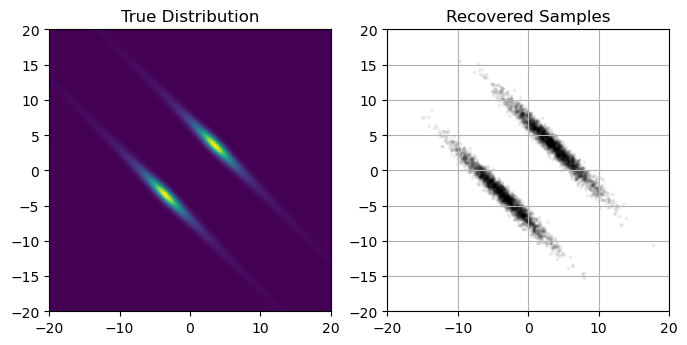

In [17]:
#-----------------------------
# Plot
fig, ax = plt.subplots(1, 2 , figsize = (8,4) )

ax[0].imshow(Z[::-1], extent = [-20,20,-20,20] )
ax[0].axis('square')
ax[0].set_title("True Distribution")

#-----------------------------
# get posterior samples
predictive_MCMClike = Predictive(guide_multimodal, params=svi_multimodal_result.params, num_samples=5000)
posterior_samples = predictive_MCMClike(random.PRNGKey(1))
Xsample, Ysample = posterior_samples['x'], posterior_samples['y']

ax[1].scatter(Xsample,Ysample, s=3, c='k', alpha=0.05)
ax[1].grid()
ax[1].axis('square')
ax[1].set_xlim(-20,20), ax[1].set_ylim(-20,20)
ax[1].set_title("Recovered Samples")

#-----------------------------
plt.show()

### Autoguides: Simpler & Faster <a id='autoguides'></a>
So far we've only looked at guides that we've explicitly constructed ourselves using NumPyro primitives. This approach gives us a lot of control and flexibility, but can get overly tedious if we're working with many parameters. NumPyro presents an alternative in [autoguides](https://num.pyro.ai/en/latest/_modules/numpyro/infer/autoguide.html), handy utilities that _automatically_ construct guides for a single NumPyro model in a single line of code.

Autoguides are limited in that they only give a small family of guides to fit, namely variations on Gaussian distributions (uncorrelated, correlated, the Laplace approximation etc), but have the advantage of being blindingly easy to use and scaling much more easily into high dimensions. In this quick example I'll show how we can use an autoguide to construct a 2D multivariate distribution. I'll start by defining a toy model in NumPyro, specifically a 2D Gaussian with $\sigma_1=1, \sigma_2 =3$ and angled at $45\degree$. 

Notice that I've used an _improper_ prior in this model, letting $x$ and $y$ be fully unconstrained. I could have just as easily used vague normal distributions to the same end, but I've opted to use these unbounded uniform distributions for neatness.

In [18]:
sig1, sig2, theta = 1.0, 3.0, 45*np.pi/180 # Variances and angle of gaussian

def factor(x,y):
    # The PDF to feed into NumPyro
    c,s = jnp.cos(theta), jnp.sin(theta)
    log_fac = -1.0 / 2.0 * ( ( (c*x- s*y) / sig1 )**2 + ( (s*x + c*y) / sig2)**2 )
    return(jnp.exp(log_fac))

def model_forauto():
    # NumPyro model using factor()
    x = numpyro.sample('x', numpyro.distributions.ImproperUniform(constraints.real, (), () ) )
    y = numpyro.sample('y', numpyro.distributions.ImproperUniform(constraints.real, (), () ) )

    log_fac = jnp.log(factor(x,y))
    numpyro.factor('logfac', log_fac)

Now, we have NumPyro generate a guide for us by feeding the model into an `infer.autofuide.AutoMultivariateNormal` object. In one line, this generates a guide that will fit a multivariate normal distribution, fully parameterized and ready to roll in an SVI optimization:

In [19]:
optimizer_forauto = numpyro.optim.Adam(step_size=0.0005)

autoguide = numpyro.infer.autoguide.AutoMultivariateNormal(model_forauto)

autosvi = SVI(model_forauto, autoguide, optim = optimizer_forauto, loss=Trace_ELBO())
autosvi_result = autosvi.run(random.PRNGKey(2), 50000)

100%|███| 50000/50000 [00:03<00:00, 13856.05it/s, init loss: 3.3177, avg. loss [47501-50000]: -2.9368]


Plotting the output of this autoguide, we see that it's recovered the gaussian distribution without any hiccups:

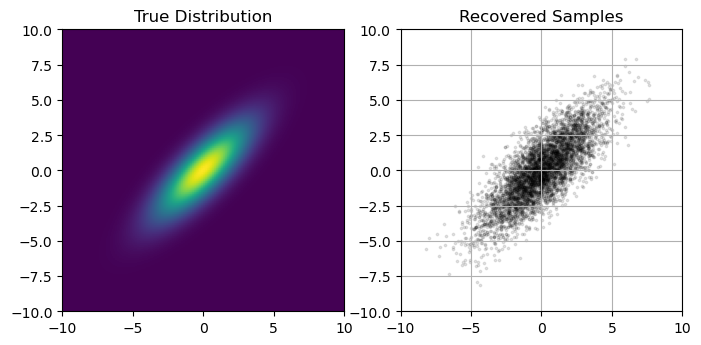

In [23]:
#-----------------------------
# Plot
fig, ax = plt.subplots(1, 2 , figsize = (8,4) )

exmin, exmax = -10.0, 10.0

X, Y = np.meshgrid(np.linspace(exmin,exmax,128),np.linspace(exmin,exmax,128))
Z = factor(X,Y)
ax[0].imshow(Z[::-1], extent = [exmin, exmax, exmin, exmax])
ax[0].axis('square')
ax[0].set_title("True Distribution")

#-----------------------------
# get posterior samples
predictive_MCMClike = Predictive(autoguide, params=autosvi_result.params, num_samples=5000)
posterior_samples = predictive_MCMClike(random.PRNGKey(1))
Xsample, Ysample = posterior_samples['x'], posterior_samples['y']

ax[1].scatter(Xsample,Ysample, s=3, c='k', alpha=0.1)
ax[1].grid()
ax[1].axis('square')
ax[1].set_xlim(exmin,exmax), ax[1].set_ylim(exmin,exmax)
ax[1].set_title("Recovered Samples")

#-----------------------------
plt.show()

**Recovering Covariance Matrix**  
We could estimate the mean and covariance matrix of the posterior from these samples alone, but we can also extract them directly from the SVI run. `AutoguideMultivariate` stores its covariance results in the lower triangular [Cholesky Matrix](https://en.wikipedia.org/wiki/Cholesky_decomposition), a sort of "square root" of the covariance matrix:

$$
    C^{-1} = L L^T
$$

We can access this from the SVI results with `.params['auto_scale_tril']`, and use then use this to reconstruct the covariance matrix. For the sake of comparison, we can then determine its principle axis and variances along these axis from the eigenvalues / vectors. 

There's only one hitch: the normal distribution and resulting $L$ matrix are defined in terms of _unconstrained_ parameter space values, and so the $C$ recovered above can be in the wrong coordinate system depending on your priors. This results in a covariance matrix that can be hard to interpret, as the constrained / unconstrained transformations aren't straightforward and change across parameter space. In this example, we've side-stepped this by using the unconstrained improper prior `ImproperUniform`.

In [24]:
# Get Lower Triangluar Cholesky Matrix and recover covariance matrix
L = autosvi_result.params['auto_scale_tril']
COVAR_REC = jnp.dot(L,L.T)

print("Recovered covariance matrix:")
print(COVAR_REC.round(3))

# Get eigenvalues / vectors
sigs, us = jnp.linalg.eig(COVAR_REC)

print("Recovered Variances:")
sig1_rec, sig2_rec  = jnp.real(sigs)**(1.0/2.0)
print("σ1 = %0.2f, σ2 = %0.2f" %(sig1_rec, sig2_rec))

print("Recovered Contour Angle:")
u1, u2 = jnp.real(us)
thet_rec = np.arctan(u1[1] / u1[0])
print("θ = %0.2f°" %(thet_rec * 180/ np.pi))

Recovered covariance matrix:
[[4.918 4.03 ]
 [4.03  5.177]]
Recovered Variances:
σ1 = 1.01, σ2 = 3.01
Recovered Contour Angle:
θ = 44.08°
